In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.gridspec as gridspec 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import random
import warnings

In [3]:
# Defaults

plt.style.use("seaborn-poster")
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("take_home_assign_set.csv")

## Exploratory Data Analysis

In [5]:
df.head()

,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output
0,63,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,0,0,1,1
1,37,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,0,0,2,1
2,41,0,Typical angina,130,204,No,Normal,172,No,1.4,2,0,2,1
3,56,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,2,0,2,1
4,57,0,NaN,120,354,No,ST-T wave normality,163,Yes,0.6,2,0,2,1


In [6]:
df.shape

(303, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  303 non-null    int64  
 1   gender               303 non-null    int64  
 2   chest_pain_type      160 non-null    object 
 3   rest_blood_pressure  303 non-null    int64  
 4   cholesterol          303 non-null    int64  
 5   fast_blood_sugar     303 non-null    object 
 6   rest_ecg             303 non-null    object 
 7   max_heart_rate       303 non-null    int64  
 8   ex_ind_ang           303 non-null    object 
 9   prev_peak            303 non-null    float64
 10  slope                303 non-null    int64  
 11  vessels_num          303 non-null    int64  
 12  thal_result          303 non-null    int64  
 13  output               303 non-null    int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 33.3+ KB


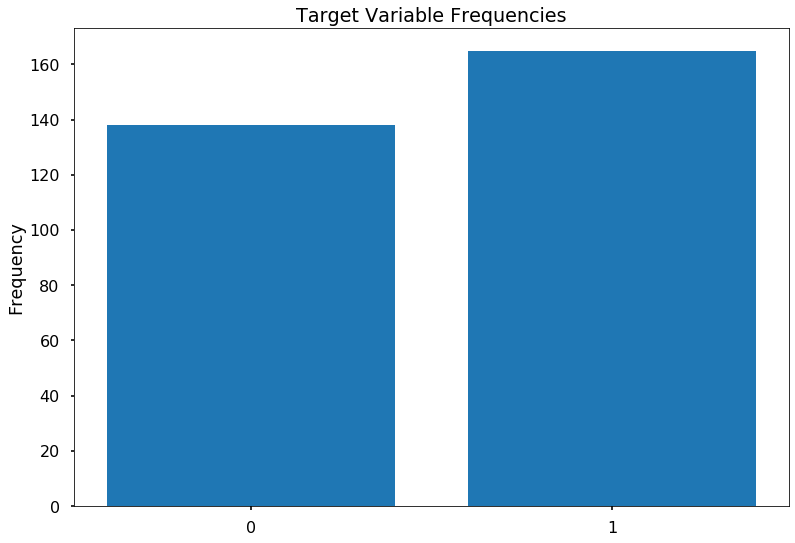

In [8]:
target = Counter(df["output"])
plt.bar(target.keys(), target.values())
plt.xticks([0,1])
plt.title("Target Variable Frequencies")
plt.ylabel("Frequency")
plt.show()

No significant class imbalance.

In [8]:
df.isna().sum()

age                      0
gender                   0
chest_pain_type        143
rest_blood_pressure      0
cholesterol              0
fast_blood_sugar         0
rest_ecg                 0
max_heart_rate           0
ex_ind_ang               0
prev_peak                0
slope                    0
vessels_num              0
thal_result              0
output                   0
dtype: int64

The 'chest_pain_type' column is the only column containing missing values. I will look into this in the context of the other categorical variables.

### Categorical Variables

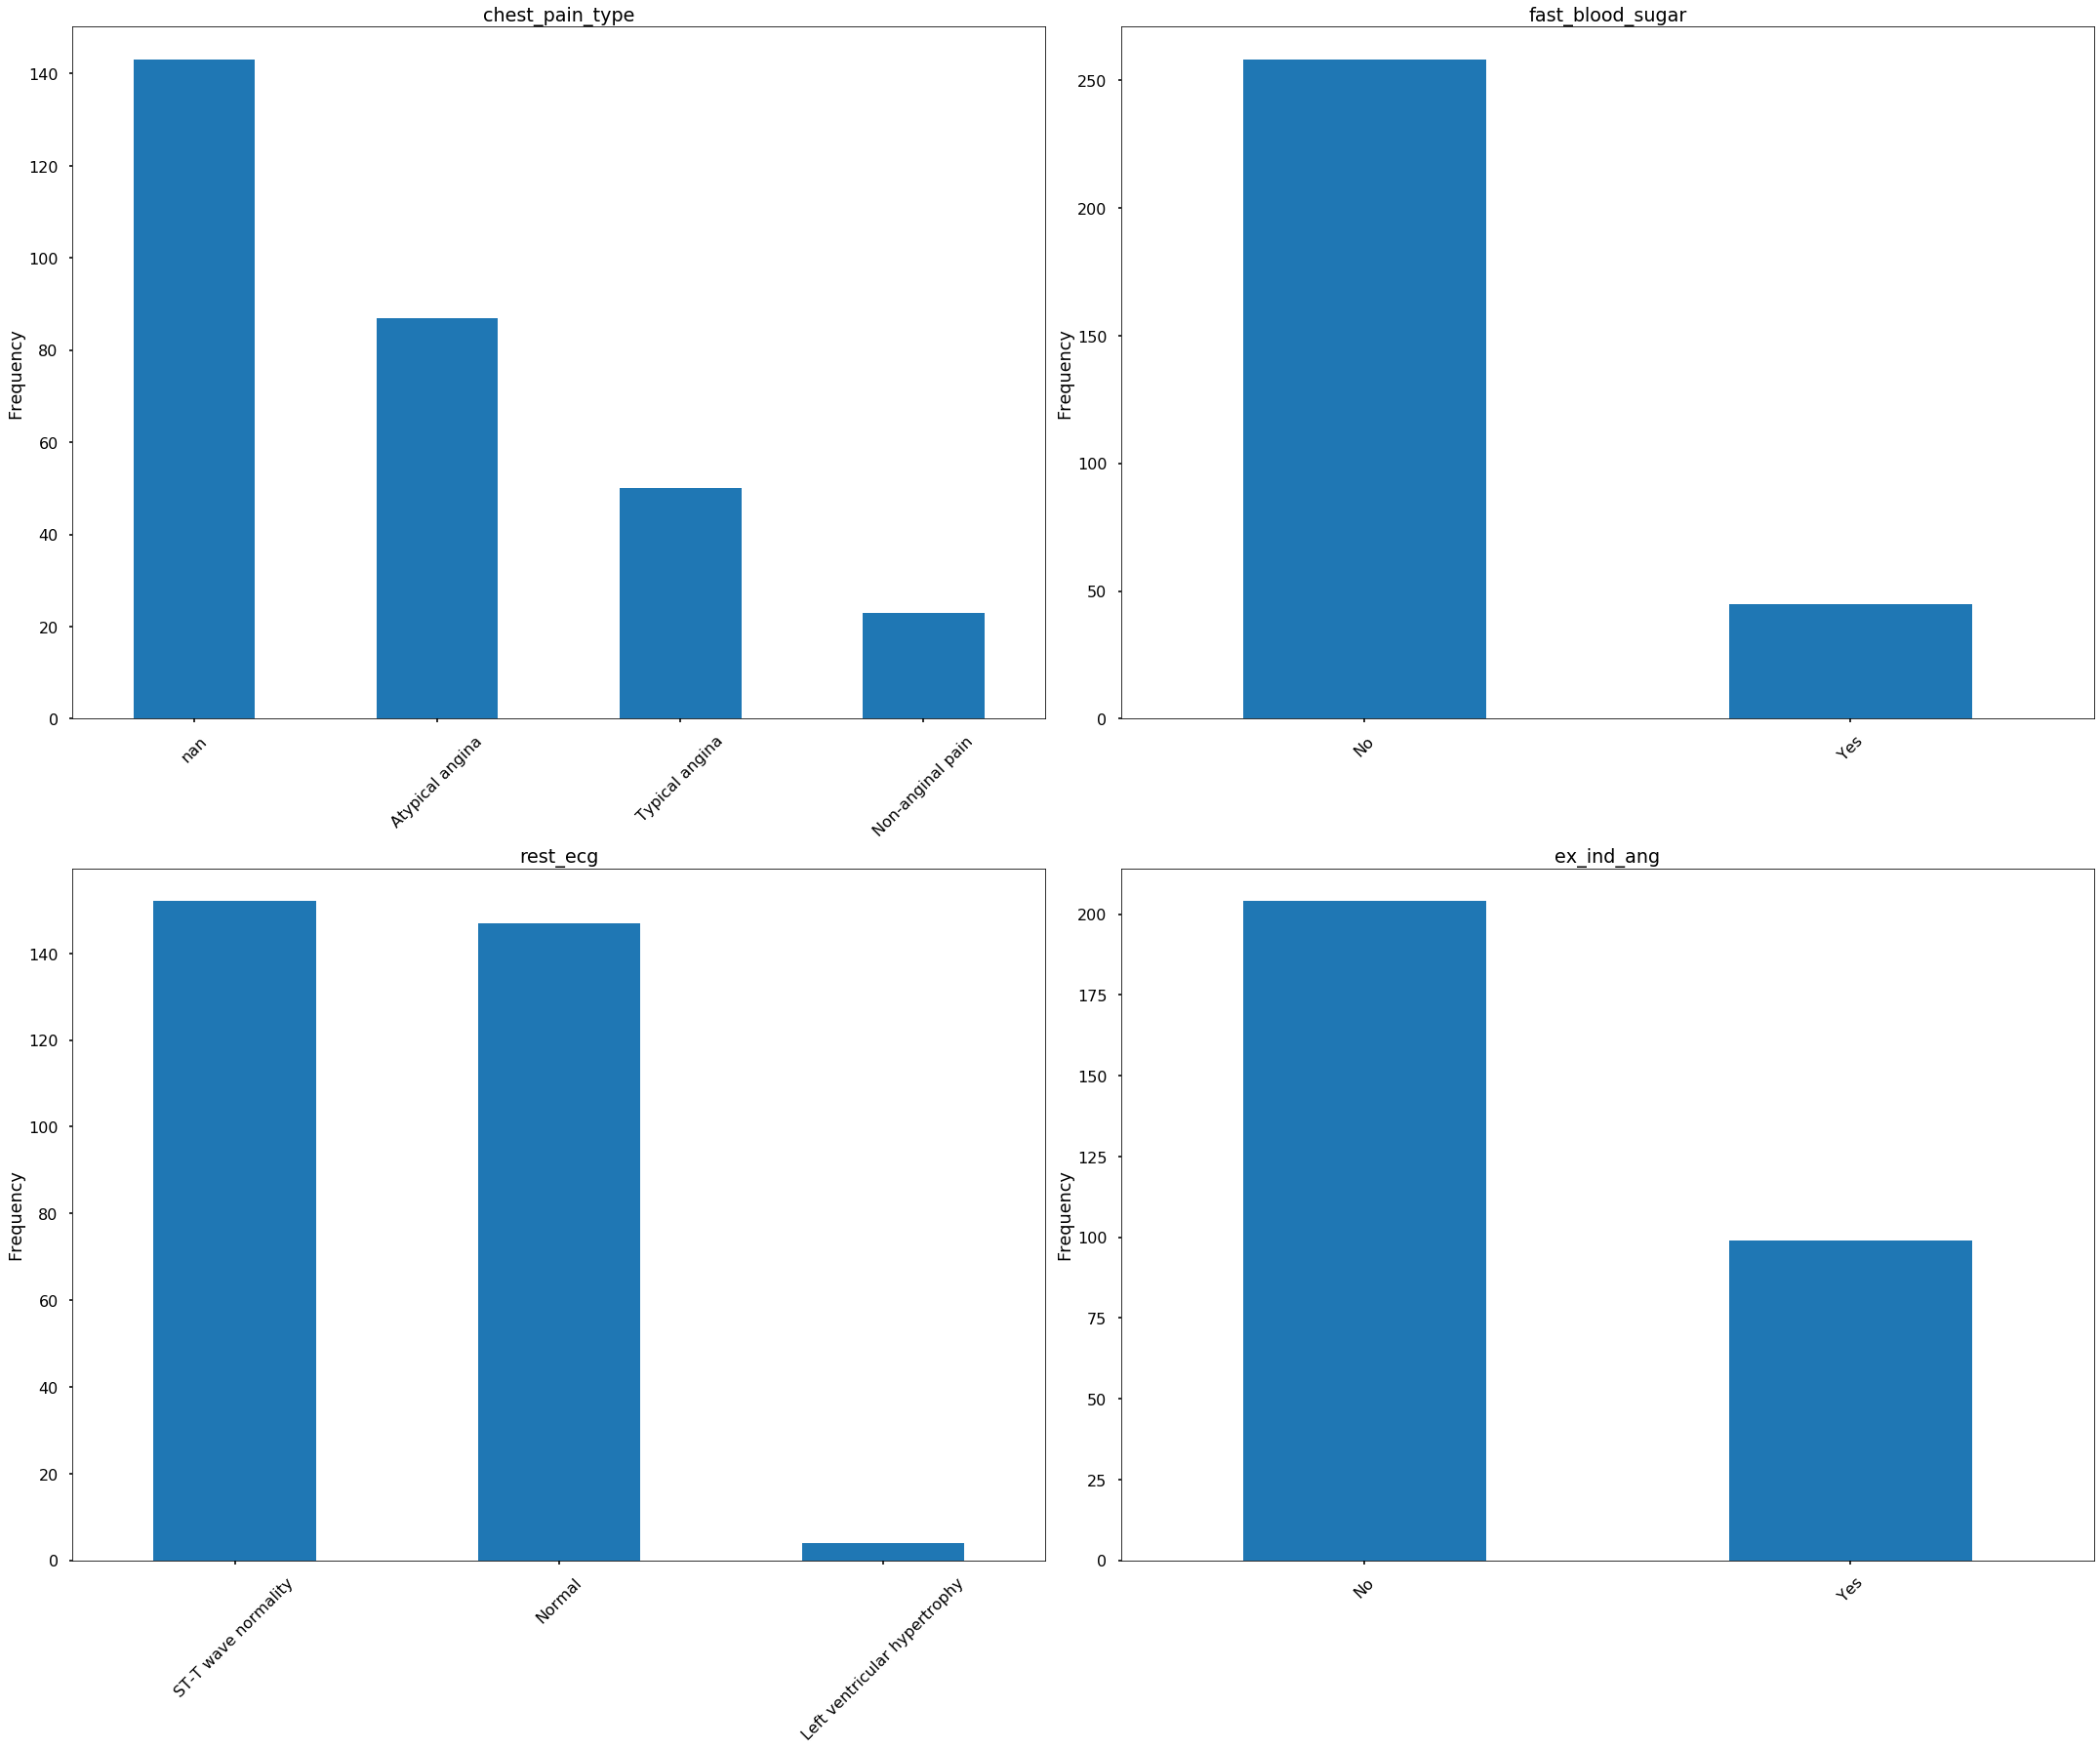

In [9]:
categorical = list(df.select_dtypes(include=["object"]).columns)

grid = gridspec.GridSpec(2,2)
plt.figure(figsize=[30,25])

for n, cat in enumerate(categorical):
    ax = plt.subplot(grid[n])
    val_counts = df[cat].value_counts(dropna=False)
    val_counts.plot(kind="bar")
    plt.title(cat)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.tight_layout()

While missing values make up a large proportion of the chest_pain_type column, the information document states that there are four types of Chest Pain, one of which is Asymptomatic. Therefore it is likely fine to assume that the missing values in the dataset are Asymptomatic. However, just to confirm this I will have a look at whether these instances seem to have a lower chance of heart attack.

In [10]:
df["chest_pain_type"].fillna("Asymptomatic", inplace=True)
chest_pain = df.groupby("chest_pain_type")["output"].agg(["sum", "count", "mean"])
chest_pain

,sum,count,mean
chest_pain_type,,,
Asymptomatic,39,143,0.272727
Atypical angina,69,87,0.793103
Non-anginal pain,16,23,0.695652
Typical angina,41,50,0.820000


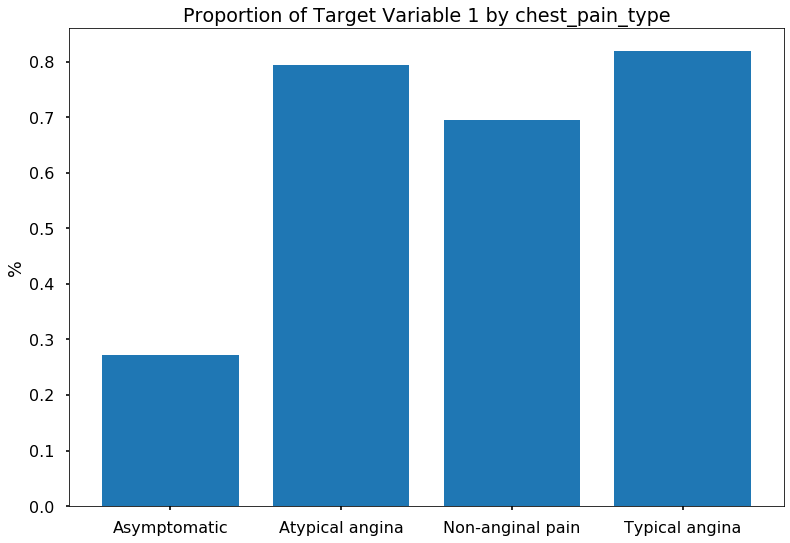

In [11]:
plt.bar(chest_pain.index, chest_pain["mean"])
plt.ylabel("%")
plt.title("Proportion of Target Variable 1 by chest_pain_type")
plt.show()

This strongly suggests that the best way to move forward with this missing data is to label it as Asymptomatic and use it in my models.

In [12]:
df.isna().sum()

age                    0
gender                 0
chest_pain_type        0
rest_blood_pressure    0
cholesterol            0
fast_blood_sugar       0
rest_ecg               0
max_heart_rate         0
ex_ind_ang             0
prev_peak              0
slope                  0
vessels_num            0
thal_result            0
output                 0
dtype: int64

As there is a similar split between 'normal' rest_ecg instances and 'non-normal' instances (ST-T wave normality and Left Ventricular Hypertrophy), I want to look at whether this could be a strong indicator of the target variable.

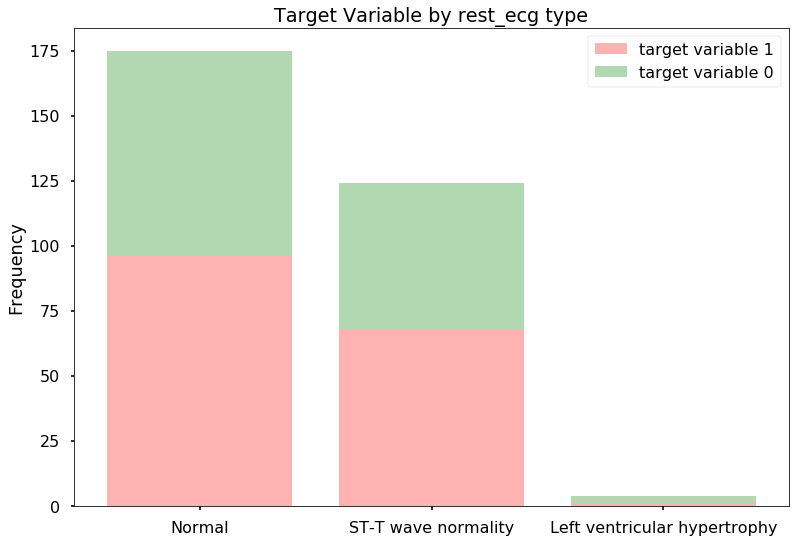

In [13]:
tv1 = df[df["output"] == 1]
tv0 = df[df["output"]==0]

plt.bar(tv1["rest_ecg"].unique(), tv1["rest_ecg"].value_counts(), label="target variable 1", color="r", alpha=0.3)
plt.bar(tv0["rest_ecg"].unique(), tv0["rest_ecg"].value_counts(), bottom=tv1["rest_ecg"].value_counts(), 
        label="target variable 0", color="g", alpha=0.3)
plt.title("Target Variable by rest_ecg type")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [14]:
print(tv0["rest_ecg"].value_counts())
print(79/len(tv0))

Normal                          79
ST-T wave normality             56
Left ventricular hypertrophy     3
Name: rest_ecg, dtype: int64
0.572463768115942


So actually having a 'Normal' rest_ecg isn't as strong a predictor of a 0 target variable as I had hoped. I thought that perhaps a large proportion of the 0 target variable instances would have a 'Normal' rest_ecg, however this is actually just over 55%.

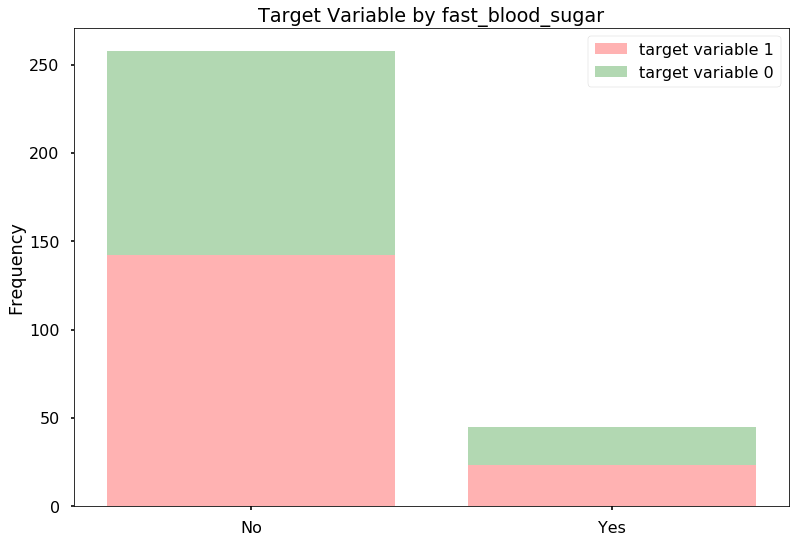

In [15]:
plt.bar(sorted(tv1["fast_blood_sugar"].unique()), tv1["fast_blood_sugar"].value_counts(), label="target variable 1", 
        color="r", alpha=0.3)
plt.bar(sorted(tv0["fast_blood_sugar"].unique()), tv0["fast_blood_sugar"].value_counts(), 
        bottom=tv1["fast_blood_sugar"].value_counts(), 
        label="target variable 0", color="g", alpha=0.3)
plt.title("Target Variable by fast_blood_sugar")
plt.ylabel("Frequency")
plt.legend()
plt.show()

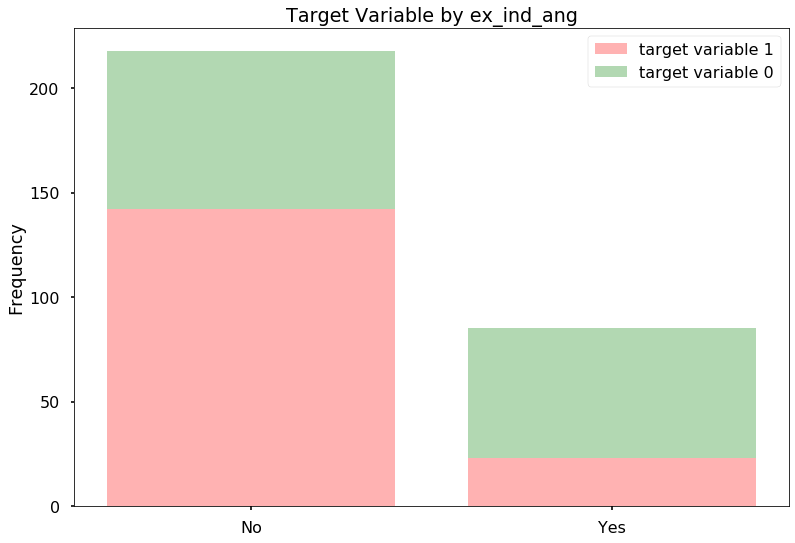

In [16]:
plt.bar(sorted(tv1["ex_ind_ang"].unique()), tv1["ex_ind_ang"].value_counts(), label="target variable 1", color="r", alpha=0.3)
plt.bar(sorted(tv0["ex_ind_ang"].unique()), tv0["ex_ind_ang"].value_counts(), bottom=tv1["ex_ind_ang"].value_counts(), 
        label="target variable 0", color="g", alpha=0.3)
plt.title("Target Variable by ex_ind_ang")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Continuous Variables

In [17]:
cont_to_analyse = ["age", "rest_blood_pressure", "cholesterol", "max_heart_rate", "prev_peak"]

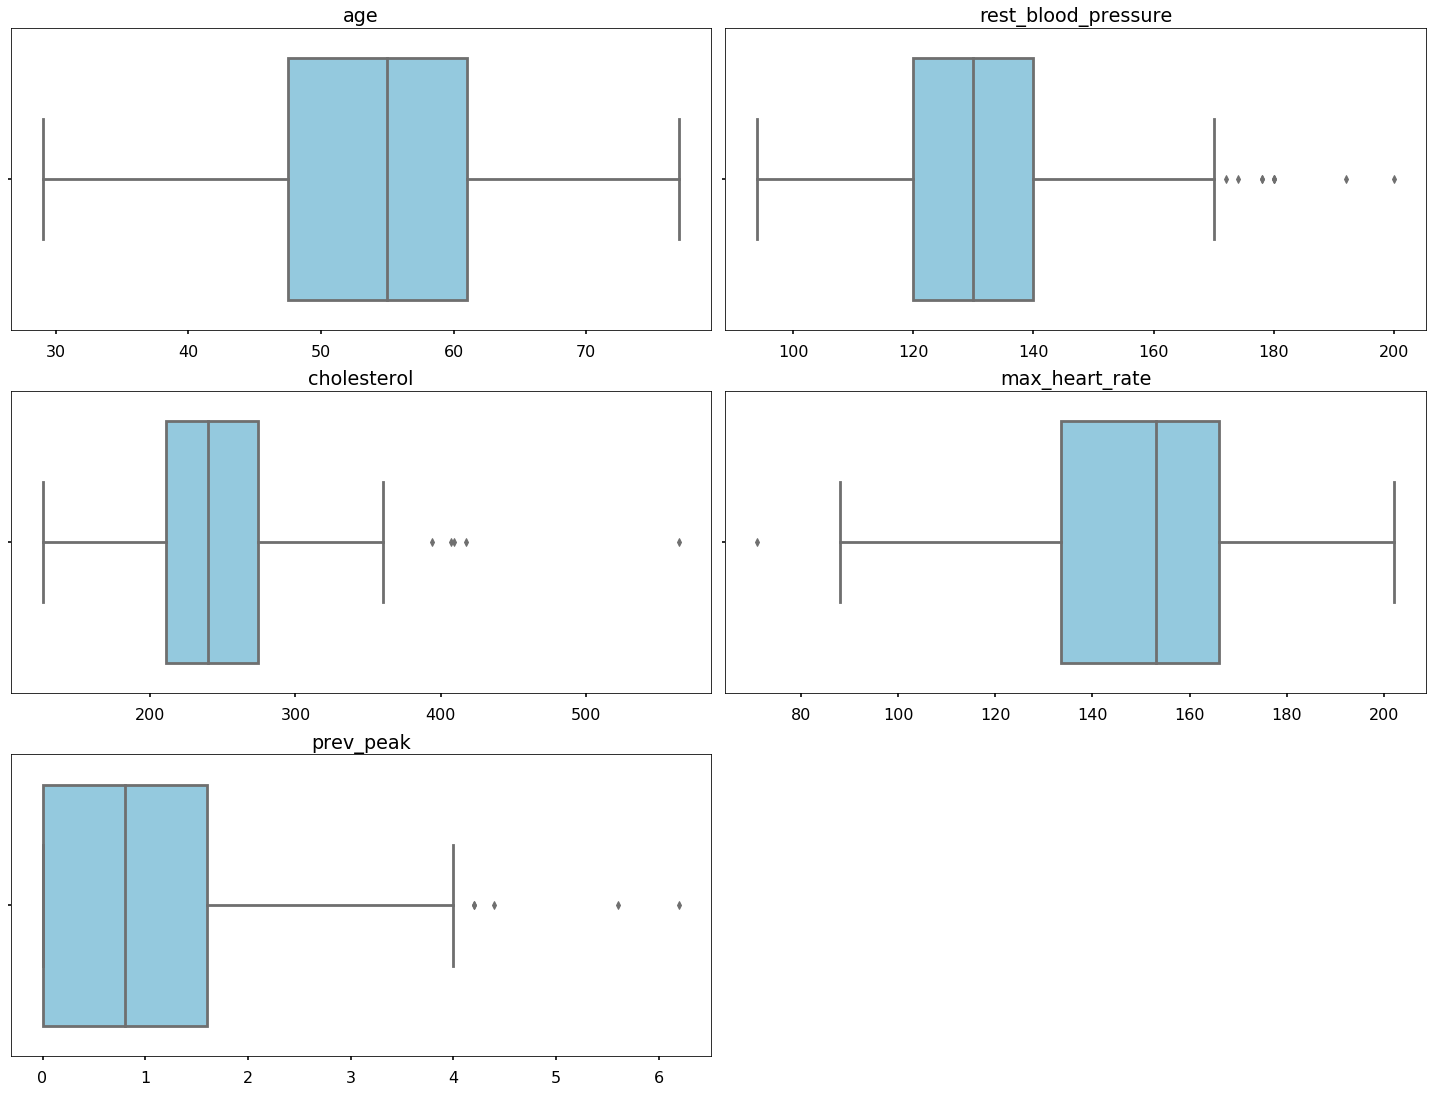

In [18]:
grid2 = gridspec.GridSpec(6,2)
plt.figure(figsize=[20,30])

for n, col in enumerate(cont_to_analyse):
    
    ax = plt.subplot(grid2[n])
    sns.boxplot(df[col], color="skyblue")

    ax.set_title(col)
    ax.set_xlabel("")
    plt.tight_layout()
    
plt.show()

Looking at the boxplots, the only significant outlier seems to be the cholesterol of over 500, so I will remove this instance.

In [19]:
before_out = df["cholesterol"].describe()
after_out = df["cholesterol"][df["cholesterol"]<500].describe()
print(f"\nBefore outlier removal:\n{before_out}")
print(f"\nAfter outlier removal:\n{after_out}")


Before outlier removal:
count    303.000000
mean     246.264026
std       51.830751
min      126.000000
25%      211.000000
50%      240.000000
75%      274.500000
max      564.000000
Name: cholesterol, dtype: float64

After outlier removal:
count    302.000000
mean     245.211921
std       48.567877
min      126.000000
25%      211.000000
50%      240.000000
75%      274.000000
max      417.000000
Name: cholesterol, dtype: float64


In [20]:
# Remove cholesterol outlier

df = df[df["cholesterol"]<500]

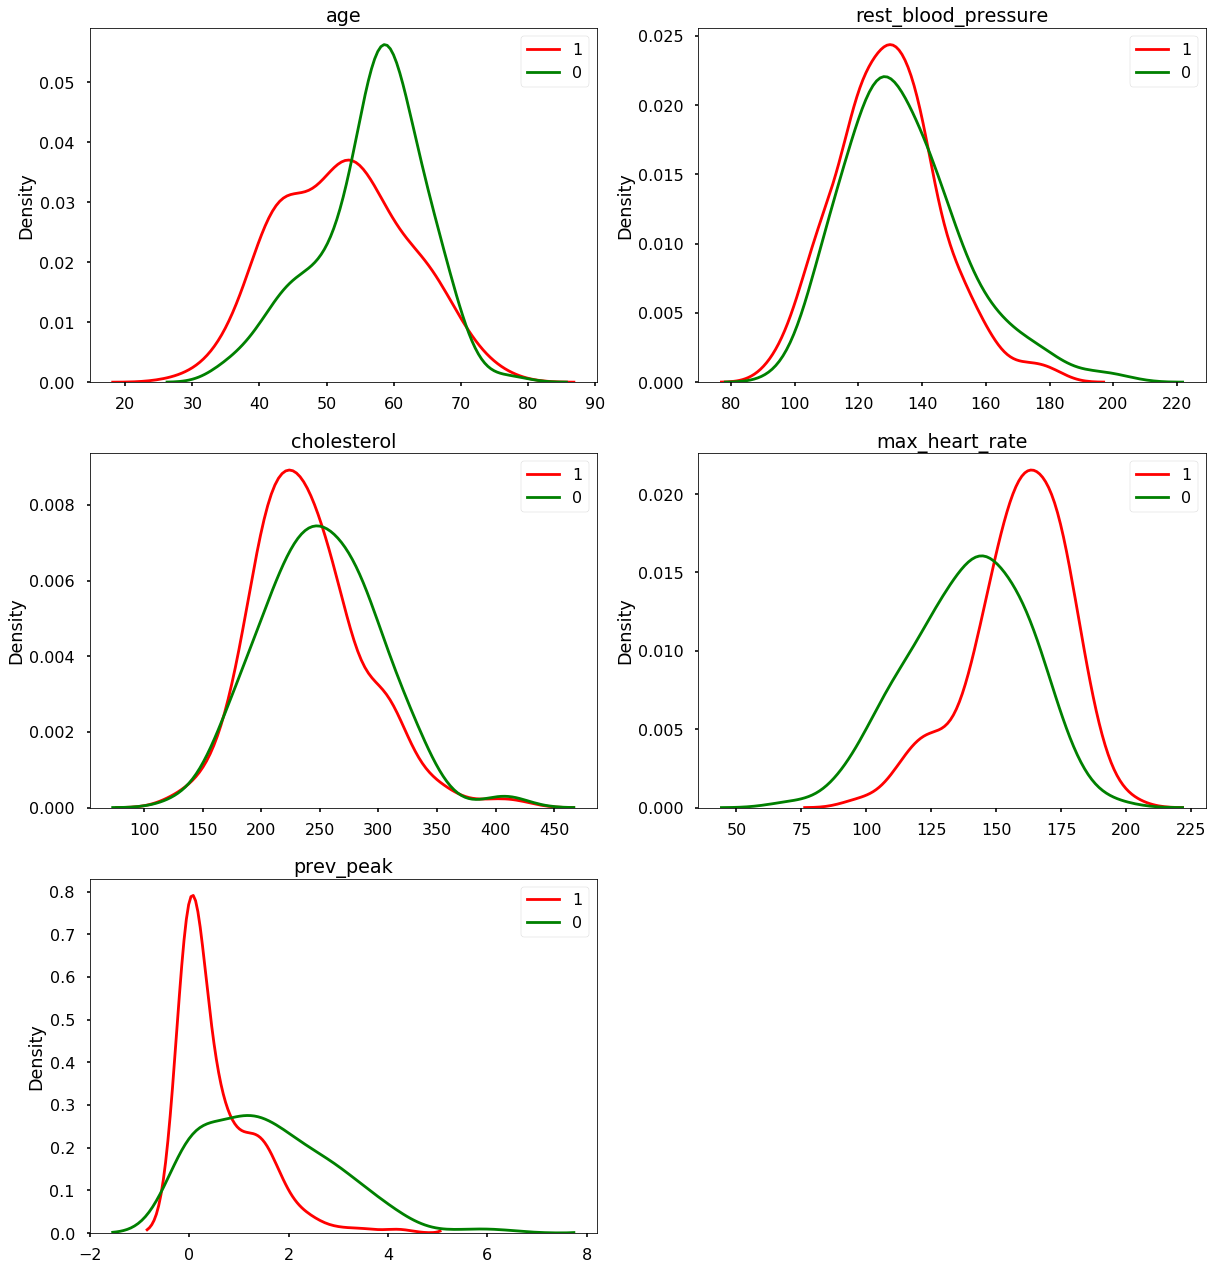

In [21]:
grid2 = gridspec.GridSpec(4,2)
plt.figure(figsize=[20,30])

for n, col in enumerate(cont_to_analyse):
    
    ax = plt.subplot(grid2[n])
    sns.distplot(df[col][df["output"]==1], bins=50, color="r", label=1, hist=False)
    sns.distplot(df[col][df["output"]==0], bins=50, color="g", label=0, hist=False)
    
    ax.set_ylabel("Density")
    ax.set_title(col)
    ax.set_xlabel("")
    
plt.show()

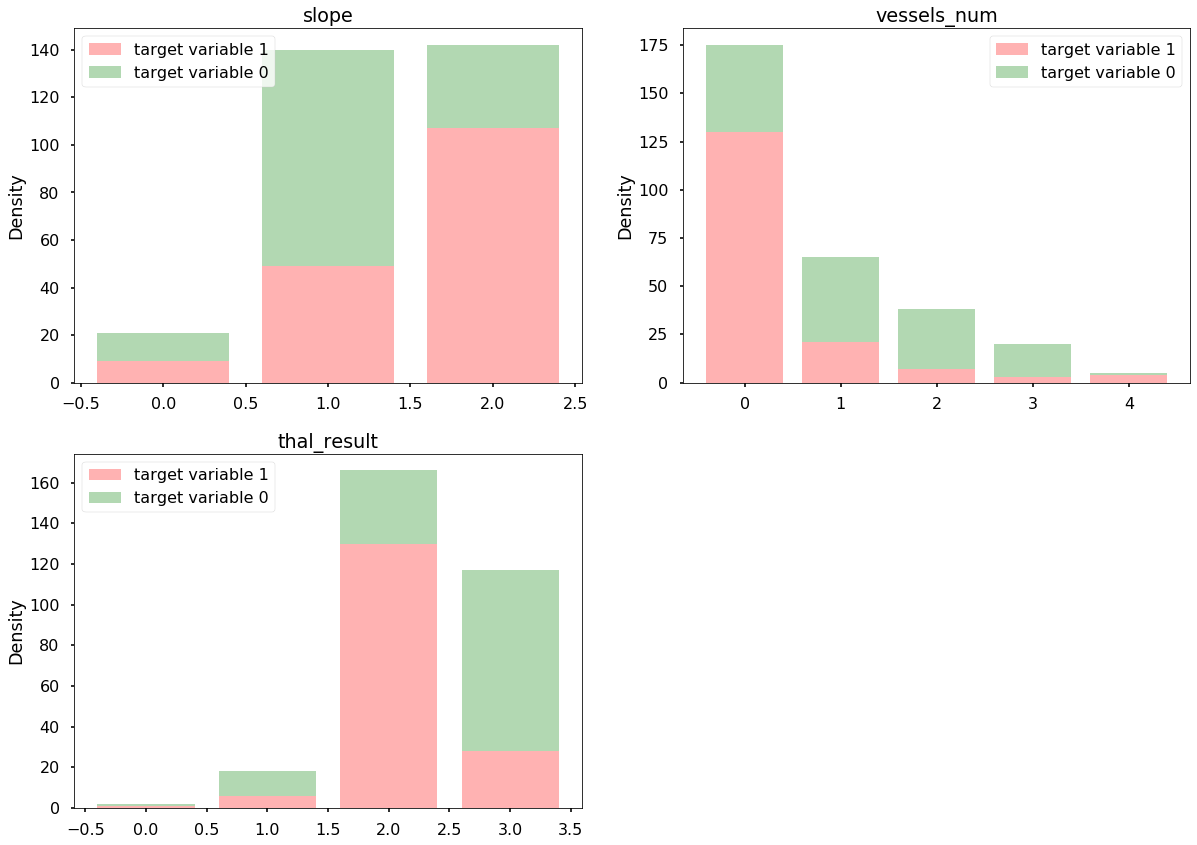

In [22]:
others = ["slope", "vessels_num", "thal_result"]

grid3 = gridspec.GridSpec(4,2)
plt.figure(figsize=[20,30])

for n, col in enumerate(others):
    
    ax = plt.subplot(grid3[n])
    plt.bar(sorted(tv1[col].unique()), tv1[col].value_counts().sort_index(0), 
            alpha=0.3, label="target variable 1", color="r")
    plt.bar(sorted(tv0[col].unique()), tv0[col].value_counts().sort_index(0), 
            alpha=0.3, label="target variable 0",
            color="g", bottom=tv1[col].value_counts().sort_index(0))

    
    ax.set_ylabel("Density")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.legend()
    
plt.show()


Looking at the work above, it seems as though the most promising indicators of a heart attack are:
* chest_pain_type 
* max_heart_rate
* prev_peak
* slope
* vessels_num 
* thal_result
* ex_ind_ang

In [23]:
# Re-order columns for correlation matrix

cols = list(df.columns)
cols.remove("output")
cols.append("output")

df = df[cols]
cols

['age',
 'gender',
 'chest_pain_type',
 'rest_blood_pressure',
 'cholesterol',
 'fast_blood_sugar',
 'rest_ecg',
 'max_heart_rate',
 'ex_ind_ang',
 'prev_peak',
 'slope',
 'vessels_num',
 'thal_result',
 'output']

In [24]:
df_corr = df.corr()
df_corr

,age,gender,rest_blood_pressure,cholesterol,max_heart_rate,prev_peak,slope,vessels_num,thal_result,output
age,1.000000,-0.092298,0.285074,0.198768,-0.402041,0.208534,-0.166471,0.280763,0.063155,-0.230720
gender,-0.092298,1.000000,-0.061698,-0.180288,-0.041983,0.098835,-0.034012,0.115297,0.216728,-0.277867
rest_blood_pressure,0.285074,-0.061698,1.000000,0.152531,-0.045357,0.195103,-0.123786,0.099375,0.065977,-0.142466
cholesterol,0.198768,-0.180288,0.152531,1.000000,-0.020472,0.047183,0.009799,0.090977,0.081377,-0.111147
max_heart_rate,-0.402041,-0.041983,-0.045357,-0.020472,1.000000,-0.345162,0.388160,-0.212357,-0.098362,0.421096
prev_peak,0.208534,0.098835,0.195103,0.047183,-0.345162,1.000000,-0.577124,0.224102,0.208964,-0.432927
slope,-0.166471,-0.034012,-0.123786,0.009799,0.388160,-0.577124,1.000000,-0.081817,-0.102636,0.348569
vessels_num,0.280763,0.115297,0.099375,0.090977,-0.212357,0.224102,-0.081817,1.000000,0.154943,-0.390431
thal_result,0.063155,0.216728,0.065977,0.081377,-0.098362,0.208964,-0.102636,0.154943,1.000000,-0.348641
output,-0.230720,-0.277867,-0.142466,-0.111147,0.421096,-0.432927,0.348569,-0.390431,-0.348641,1.000000


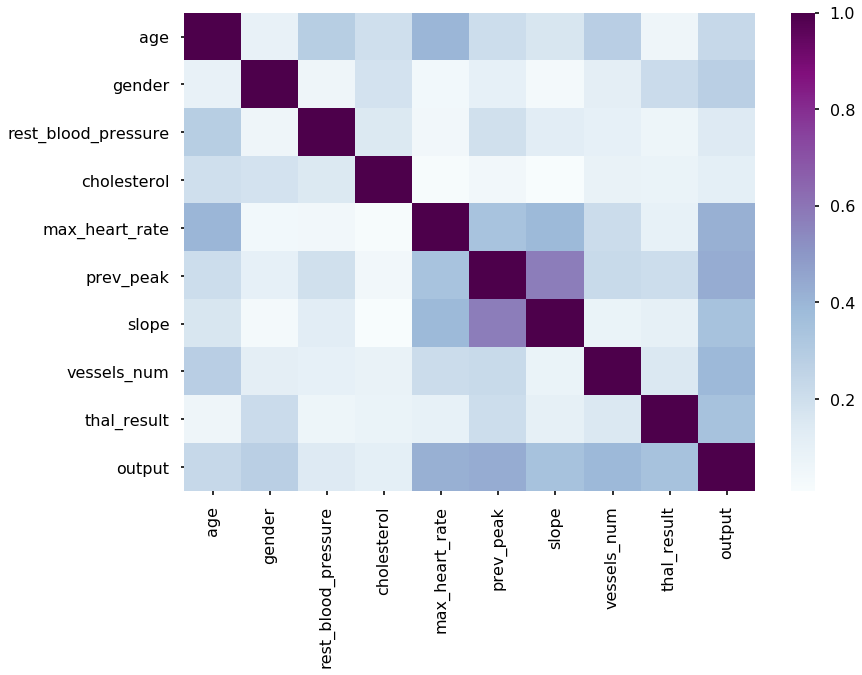

In [25]:
sns.heatmap(np.abs(df_corr), cmap="BuPu")
plt.show()

As the slope feature seems to be quite highly correlated with both prev_peak and to a lesser extent, max_heart_rate, I am going to remove slope from the training set to reduce complexity and overfitting.

# Preprocessing and Feature Selection

In [26]:
# Binarise fast_blood_sugar and ex_ind_ang

yes_no = {"Yes":int(1), "No":int(0)}

for i in ["fast_blood_sugar", "ex_ind_ang"]:
    
    df[f"binary_{i}"] = df[i].map(yes_no)
    df.drop(i, inplace=True, axis=1)

As there is no clear order for the rest_ecg and chest_pain_type variables, I will use pd.get_dummies to prepare them for use in the model.

In [27]:
rest_ecg_dum = pd.get_dummies(df["rest_ecg"], prefix="rest_ecg", drop_first=True)
df = pd.concat([df, rest_ecg_dum], axis=1)

chest_pain_dum = pd.get_dummies(df["chest_pain_type"], prefix = "cp", drop_first=True)
df = pd.concat([df,chest_pain_dum], axis=1)

df.drop(["rest_ecg", "chest_pain_type"], axis=1, inplace=True)

In [28]:
df.sample(10)

,age,gender,rest_blood_pressure,cholesterol,max_heart_rate,prev_peak,slope,vessels_num,thal_result,output,binary_fast_blood_sugar,binary_ex_ind_ang,rest_ecg_Normal,rest_ecg_ST-T wave normality,cp_Atypical angina,cp_Non-anginal pain,cp_Typical angina
235,51,1,140,299,173,1.6,2,0,3,0,0,1,0,1,0,0,0
123,54,0,108,267,167,0.0,2,0,2,1,0,0,1,0,1,0,0
242,64,1,145,212,132,2.0,1,2,1,0,0,0,1,0,0,0,0
171,48,1,110,229,168,1.0,0,0,3,0,0,0,0,1,0,0,1
174,60,1,130,206,132,2.4,1,2,3,0,0,1,1,0,0,0,0
78,52,1,128,205,184,0.0,2,0,2,1,1,0,0,1,0,0,1
44,39,1,140,321,182,0.0,2,0,2,1,0,0,1,0,1,0,0
282,59,1,126,218,134,2.2,1,1,1,0,1,0,0,1,1,0,0
272,67,1,120,237,71,1.0,1,0,2,0,0,0,0,1,0,0,0
248,54,1,192,283,195,0.0,2,1,3,0,0,0,1,0,0,0,1


I am going to drop a number of features as they seem to either have little predictive power. 

I am dropping the slope feature due to its correlation with prev_peak. I am also dropping the max_heart_rate variable as it seems to have some correlation with a number of the other numerical features. This is one that I will look at again after evaluating the model as it could either be of some use or could just mislead the model.

## train_test_split - test_size

I have set the test_size in train_test_split to a default test size of 0.25. 
When using 0.2, the performance of my models seemed to be highly susceptible to variations in the test set.
Using 0.3 resulted in the train set scoring less well than the test set on occasion and also cut down my already quite small training set.

0.25 seems to strike the best balance between these two options, with my train set predominantely outscoring the test set and my model performance being less affected by particular characteristics of the test set.

## Scoring metric choice

I have chosen recall as the scoring metric that my GridSearchCV optimises for in the models below.

As I don't really want the classifier to be missing cases where a heart attack is likely, the model is best suited to minimising false negatives. However I have also set up a function to produce a detailed list of scores including roc_auc and f1_score. As a model with perfect recall but very poor precision would result in a large number of people being told they were at a high risk of heart attack (false positives), this would also not be ideal and therefore needs to be controlled.

# Model Training

In [29]:
def model(clf, params, *args):
    
    """
    Function to train a model, produce predictions and then analyse the performance of the model.
    """
    
    gcv = GridSearchCV(clf, params, cv=10)
    
    gcv.fit(X_train, y_train)
    
    train_pred = gcv.predict(X_train)
    test_pred = gcv.predict(X_test)
    
    print("\n********************************")
    print(f"Estimator: {gcv.best_estimator_}")
    print(f"Train Accuracy Score: {accuracy_score(train_pred, y_train)}")
    print(f"Test Accuracy Score: {accuracy_score(test_pred, y_test)}")
    print(f"Test Recall Score: {recall_score(test_pred, y_test)}")
    print(f"Test Precision Score: {precision_score(test_pred, y_test)}")
    print(f"Test ROC_AUC Score: {roc_auc_score(test_pred, y_test)}")
    print(f"f1 Score: {f1_score(test_pred, y_test)}")
    print(f"Confusion Matrix: \n{confusion_matrix(test_pred, y_test)}")
    
    return gcv.best_estimator_

In [30]:
def prepare_data(df, drops, test_size):
    
    """
    Function to preprocess the data in a controllable and standardised manner, while allowing for small alterations.
    """
    
    working = df.drop(drops, axis=1)
    X = working.drop("output", axis=1).values
    y = working["output"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

In [31]:
# Alter columns in model

feats_to_drop = ["slope", "rest_blood_pressure", "cholesterol", 
                 "rest_ecg_ST-T wave normality", "rest_ecg_Normal", "age",
                "max_heart_rate"]

feats_to_drop_keep_max_heart = ["slope", "rest_blood_pressure", "cholesterol", 
                 "rest_ecg_ST-T wave normality", "rest_ecg_Normal", "age"]

## KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier()

knn_params = {"n_neighbors":np.arange(3,20,2)}

In [33]:
# Train and evaluate knn classifier with standard features dropped

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop, 0.25)
knn_model1 = model(knn, knn_params, X_train, X_test, y_train, y_test)


********************************
Estimator: KNeighborsClassifier(n_neighbors=7)
Train Accuracy Score: 0.8451327433628318
Test Accuracy Score: 0.8421052631578947
Test Recall Score: 0.8857142857142857
Test Precision Score: 0.7948717948717948
Test ROC_AUC Score: 0.8452961672473869
f1 Score: 0.8378378378378378
Confusion Matrix: 
[[33  8]
 [ 4 31]]


In [34]:
# Train and evaluate knn classifier with max_heart_rate added back into model

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop_keep_max_heart, 0.25)
knn_model2 = model(knn, knn_params, X_train, X_test, y_train, y_test)


********************************
Estimator: KNeighborsClassifier(n_neighbors=3)
Train Accuracy Score: 0.8407079646017699
Test Accuracy Score: 0.7105263157894737
Test Recall Score: 0.6976744186046512
Test Precision Score: 0.7692307692307693
Test ROC_AUC Score: 0.7124735729386892
f1 Score: 0.7317073170731708
Confusion Matrix: 
[[24  9]
 [13 30]]


## Logistic Regression

In [35]:
lr = LogisticRegression()

lr_params = {"C":[0.1, 0.5, 1, 3], "penalty":["elasticnet", "l2", "l1"], 
                  "solver":["saga", "liblinear", "lbfgs"], "l1_ratio":np.arange(0.01, 0.99, 0.01)}

In [36]:
# Train and evaluate lr classifier with standard features dropped

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop, 0.25)
lr_model1 = model(lr, lr_params, X_train, X_test, y_train, y_test)


********************************
Estimator: LogisticRegression(C=0.5, l1_ratio=0.42000000000000004, penalty='elasticnet',
                   solver='saga')
Train Accuracy Score: 0.827433628318584
Test Accuracy Score: 0.8552631578947368
Test Recall Score: 0.85
Test Precision Score: 0.8717948717948718
Test ROC_AUC Score: 0.8555555555555556
f1 Score: 0.8607594936708861
Confusion Matrix: 
[[31  5]
 [ 6 34]]


In [37]:
# Train and evaluate lr classifier with max_heart_rate added back into model

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop_keep_max_heart, 0.25)
lr_model2 = model(lr, lr_params, X_train, X_test, y_train, y_test)


********************************
Estimator: LogisticRegression(C=0.5, l1_ratio=0.01, penalty='l1', solver='liblinear')
Train Accuracy Score: 0.8495575221238938
Test Accuracy Score: 0.8552631578947368
Test Recall Score: 0.85
Test Precision Score: 0.8717948717948718
Test ROC_AUC Score: 0.8555555555555556
f1 Score: 0.8607594936708861
Confusion Matrix: 
[[31  5]
 [ 6 34]]


## Support Vector Machines

In [38]:
svm = SVC()

svm_params = {"kernel":["linear", "rbf", "poly", "sigmoid"], "C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [39]:
# Train and evaluate svm classifier with standard features dropped

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop, 0.25)
svm_model_1 = model(svm, svm_params, X_train, X_test, y_train, y_test)


********************************
Estimator: SVC(C=10)
Train Accuracy Score: 0.9292035398230089
Test Accuracy Score: 0.8289473684210527
Test Recall Score: 0.8421052631578947
Test Precision Score: 0.8205128205128205
Test ROC_AUC Score: 0.8289473684210527
f1 Score: 0.8311688311688312
Confusion Matrix: 
[[31  7]
 [ 6 32]]


In [40]:
# Train and evaluate svm classifier with max_heart_rate added back into model

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop_keep_max_heart, 0.25)
svm_model_2 = model(svm, svm_params, X_train, X_test, y_train, y_test)


********************************
Estimator: SVC(C=1, kernel='linear')
Train Accuracy Score: 0.8539823008849557
Test Accuracy Score: 0.868421052631579
Test Recall Score: 0.8717948717948718
Test Precision Score: 0.8717948717948718
Test ROC_AUC Score: 0.8683298683298684
f1 Score: 0.8717948717948718
Confusion Matrix: 
[[32  5]
 [ 5 34]]


## Random Forest Classifier

In [41]:
rf = RandomForestClassifier()

rf_params1 = {"min_samples_split":[2,5,10], "n_estimators":[100, 200], "max_depth":[10, 20, 30]}

In [42]:
# Train and evaluate rf classifier with standard features dropped

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop, 0.25)
rf_model1 = model(rf, rf_params1, X_train, X_test, y_train, y_test)


********************************
Estimator: RandomForestClassifier(max_depth=10, min_samples_split=10)
Train Accuracy Score: 0.915929203539823
Test Accuracy Score: 0.8157894736842105
Test Recall Score: 0.8378378378378378
Test Precision Score: 0.7948717948717948
Test ROC_AUC Score: 0.8163548163548163
f1 Score: 0.8157894736842105
Confusion Matrix: 
[[31  8]
 [ 6 31]]


In [43]:
# Train and evaluate rf classifier with max_heart_rate added back into model

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop_keep_max_heart, 0.25)
rf_model2 = model(rf, rf_params1, X_train, X_test, y_train, y_test)


********************************
Estimator: RandomForestClassifier(max_depth=30, min_samples_split=10)
Train Accuracy Score: 0.9292035398230089
Test Accuracy Score: 0.8421052631578947
Test Recall Score: 0.8461538461538461
Test Precision Score: 0.8461538461538461
Test ROC_AUC Score: 0.841995841995842
f1 Score: 0.8461538461538461
Confusion Matrix: 
[[31  6]
 [ 6 33]]


In [44]:
# The model above is overfitting so I am altering the hyperparameters to try and reduce this.

rf_params2 = {"min_samples_split":[5,10], "n_estimators":[20, 50, 100], "max_depth":[5, 10, 20]}

In [45]:
# Train and evaluate rf classifier with standard features dropped 

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop, 0.25)
rf_model3 = model(rf, rf_params2, X_train, X_test, y_train, y_test)


********************************
Estimator: RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=20)
Train Accuracy Score: 0.9070796460176991
Test Accuracy Score: 0.8289473684210527
Test Recall Score: 0.825
Test Precision Score: 0.8461538461538461
Test ROC_AUC Score: 0.8291666666666666
f1 Score: 0.8354430379746836
Confusion Matrix: 
[[30  6]
 [ 7 33]]


In [46]:
# Train and evaluate rf classifier with max_heart_rate added back into model 
# but also with altered hyperparameters to reduce overfitting

X_train, X_test, y_train, y_test = prepare_data(df, feats_to_drop_keep_max_heart, 0.25)
rf_model4 = model(rf, rf_params2, X_train, X_test, y_train, y_test)


********************************
Estimator: RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=20)
Train Accuracy Score: 0.9247787610619469
Test Accuracy Score: 0.8421052631578947
Test Recall Score: 0.8461538461538461
Test Precision Score: 0.8461538461538461
Test ROC_AUC Score: 0.841995841995842
f1 Score: 0.8461538461538461
Confusion Matrix: 
[[31  6]
 [ 6 33]]


## Conclusion

Having reviewed the data above, my final model is the svm_model_2, which uses a Support Vector Machine with C=1 and a linear kernel to determine how best to classify each instance.

This uses the max_heart_rate feature, which reduces overfitting and enables the classifier to achieve both high recall and precision scores on this small dataset.

While the knn_model_1 actually produces a higher recall score, it does so at significant cost to precision. This means that even though it misses one less heart attack, it misclassifies an extra three non-heart attacks as heart attacks. This is significant in a small sample like this and therefore I prefer the svm_model_2.

In [47]:
final_best_model = svm_model_2

In [48]:
final_best_model

SVC(C=1, kernel='linear')

### Limits

The primary limit in this work is the size of the dataset. With only 303 instances it is difficult to create a large enough test set without significantly hindering the training of the model.

The differences in the scores of my models is quite small, meaning that in such a small test set just one instance being classified differently can make a huge difference in the evaluation. Therefore, in order to significantly improve performance on additional unseen data it would be advisable to increase the size of the overall dataset if possible and then retrain the models.